<a href="https://colab.research.google.com/github/theostoican/MastersThesis/blob/main/Investigation_Escaping_local_minima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [110]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable

# Models

A dummy network that receives as input the precomputed incoming and outgoing weights and sets them directly.

In [111]:
torch.set_default_dtype(torch.float64)
class DummyNetwork(nn.Module):
  def __init__(self, D_in, H, D_out, w_in, w_out):
    """
    In the constructor we instantiate two nn.Linear modules and assign them as
    member variables.

    D_in: input dimension
    H: dimension of hidden layer
    D_out: output dimension of the first layer
    """
    super(DummyNetwork, self).__init__()
    self.linear1 = nn.Linear(D_in, H, bias=False)
    self.linear2 = nn.Linear(H, D_out, bias=False)
    self.linear1.weight = torch.nn.Parameter(w_in)
    self.linear2.weight = torch.nn.Parameter(w_out)
  def forward(self, x):
    """
    In the forward function we accept a Variable of input data and we must
    return a Variable of output data. We can use Modules defined in the
    constructor as well as arbitrary operators on Variables.
    """
    h_sigmoid = torch.sigmoid(self.linear1(x))
    y_pred = self.linear2(h_sigmoid)
    return y_pred

In [112]:
class TeacherNetwork(nn.Module):
  def __init__(self, D_in, H, D_out):
    """
    In the constructor we instantiate two nn.Linear modules and assign them as
    member variables.

    D_in: input dimension
    H: dimension of hidden layer
    D_out: output dimension of the first layer
    """
    super(TeacherNetwork, self).__init__()
    self.linear1 = nn.Linear(D_in, H, bias=False)
    self.linear2 = nn.Linear(H, D_out, bias=False)
    self.linear1.weight = torch.nn.Parameter(torch.transpose(torch.DoubleTensor([[0.6, -0.5, -0.2, 0.1], [0.5, 0.5, -0.6, -0.6]]), 0, 1))
    self.linear2.weight = torch.nn.Parameter(torch.transpose(torch.DoubleTensor([[1], [-1], [1], [-1]]), 0, 1))
  def forward(self, x):
    """
    In the forward function we accept a Variable of input data and we must
    return a Variable of output data. We can use Modules defined in the
    constructor as well as arbitrary operators on Variables.
    """
    h_sigmoid = torch.sigmoid(self.linear1(x))
    y_pred = self.linear2(h_sigmoid)
    return y_pred

# Dataset

In [113]:
D_in, H_teacher, H_student, D_out = 2, 4, 5, 1

def construct_dataset():
  data = []
  for y in np.arange(-5, 5.1, .25):
    for x in np.arange(-5, 5.1, .25):
      data.append([x, y])
  return data

dataset = torch.DoubleTensor(construct_dataset()) 
print(len(construct_dataset()))

1681


# Labels

In [114]:
teacher_model = TeacherNetwork(D_in, H_teacher, D_out)
y_labels = teacher_model(dataset).detach()

In [115]:
data = pd.read_csv('fixed_points.csv', float_precision='round_trip')
data = data[data['loss'] >= 1e-6]
len(data)

434

In [116]:
# 607 is the initial point that we tried on
sample_point = data.sample()
for _, sample_point in sample_point.iterrows():
  pass
print(sample_point['gradient_norm'])
print(sample_point['loss'])

2.2199816911715864e-10
7.186693917245406e-05


### Helper for extracting the weights from one data point.

In [117]:
def extract_weights(data_point):
  incoming_weights_x = [data_point['w11'],
                      data_point['w21'],
                      data_point['w31'],
                      data_point['w41'],
                      data_point['w51']]
  incoming_weights_y = [data_point['w12'],
                      data_point['w22'],
                      data_point['w32'],
                      data_point['w42'],
                      data_point['w52']]
  outgoing_weights = [data_point['a1'],
                    data_point['a2'],
                    data_point['a3'],
                    data_point['a4'],
                    data_point['a5']]
  return incoming_weights_x, incoming_weights_y, outgoing_weights

In [118]:
incoming_weights_x, incoming_weights_y, outgoing_weights = extract_weights(sample_point)
print(incoming_weights_x)
print(incoming_weights_y)
print(outgoing_weights)

[1.0642926159034056, -0.6388435375735875, -0.2044854635376129, -0.6452718990856442, -0.18452984932564703]
[0.7449805020881858, 0.7812943559561835, -0.09295294227482198, 0.7749972001612204, -0.09134363142013682]
[0.30798652520423475, 11.012091750857037, -11.775349891073175, -11.373422135714963, 11.828682992235544]


## Smallest eigenvalue using JAX

In [119]:
import jax.numpy as jnp
from jax import nn as jax_nn
from jax.config import config; config.update("jax_enable_x64", True)
jnp.set_printoptions(precision=32) 

jnp_inputs = jnp.array(construct_dataset(), dtype=jnp.float64)
jnp_labels = jnp.array(teacher_model(dataset).detach(), dtype=jnp.float64)

def predict(w_in, w_out):
  return w_out @ jnp.transpose(jax_nn.sigmoid(jnp_inputs @ jnp.transpose(w_in)))

w_in = jnp.array([[incoming_weights_x[0], incoming_weights_y[0]],
                  [incoming_weights_x[1], incoming_weights_y[1]],
                  [incoming_weights_x[2], incoming_weights_y[2]],
                  [incoming_weights_x[3], incoming_weights_y[3]],
                  [incoming_weights_x[4], incoming_weights_y[4]]], dtype=jnp.float64)
w_out = jnp.array(outgoing_weights, dtype=jnp.float64)

### Loss in JAX

Loss of the network computed in JAX.

In [120]:
def loss(w):
  w_in = w[0 : 2 * H_student].reshape(D_in, H_student).T
  w_out = w[2 * H_student : ].reshape(1, H_student)
  preds = predict(w_in, w_out).T
  return jnp.mean(jnp.mean(jnp.square(preds - jnp_labels)))
print(loss(jnp.append(w_in.T.reshape(D_in * H_student), w_out.reshape(H_student))))

7.186693917245474e-05


### Hessian in JAX

In [121]:
from jax import jacfwd, jacrev, grad
import jax

def hessian(f):
  return jacfwd(jacrev(f))

H = hessian(loss)(jnp.append(w_in.T.reshape(D_in * H_student), w_out.reshape(H_student)))

### Eigenvalues in JAX

In [122]:
evals, evectors = jnp.linalg.eig(H)

# Sanity check
for eval in jnp.array([jax.lax.imag(eval) for eval in evals]):
  assert eval == 0

evals = jnp.array([jax.lax.real(eval) for eval in evals])
evals.sort()

print(evals[-2: ])
smallest_evector = jnp.array([jax.lax.real(elem) for elem in evectors[:, jnp.argmin(evals)]])
print(smallest_evector)

[2.4565571293260932e-11 1.4543709124135564e-11]
[ 3.4643950009520001e-06  1.9649888115236787e-04 -5.1517849612759491e-07
 -2.0925122167484063e-04  7.8192875406220461e-07  2.4977998579645946e-06
  2.1591884273987628e-04  3.0296387435027621e-06 -1.8251974558878740e-04
  3.2054815340416437e-06 -7.4691055600106860e-07 -7.0710686819937785e-01
  7.0165863063078064e-04  7.0710588482271719e-01 -6.9992720932106507e-04]


## Perturbation (based on JAX evectors)

In [123]:
old_loss = loss(jnp.append(w_in.T.reshape(D_in * H_student), w_out.reshape(H_student)))

perturb_lower_bound = -8.0
perturb_upper_bound = 8.0
perturb_step = 0.01

perturb_losses = []
perturb_evals = []
perturb_grads = []

weights = jnp.append(w_in.T.reshape(D_in * H_student), w_out.reshape(H_student))
for eps in np.arange(perturb_lower_bound, perturb_upper_bound, perturb_step):
  new_weights = weights + eps * smallest_evector
  sign = 1 if eps > 0 else -1
  perturb_grads.append(jnp.linalg.norm(grad(loss)(new_weights)))
  
  H = hessian(loss)(new_weights)
  H = (H + H.T) / 2
  evals, _ = jnp.linalg.eig(H)

  perturb_evals.append(min(evals))
  perturb_losses.append(loss(new_weights))

Check the smallest eigenvectors at perturbation factor \in {-1, 1}.

In [124]:
new_weights = weights - 0.4 * smallest_evector
H = hessian(loss)(new_weights)
H = (H + H.T) / 2
evals, evectors = jnp.linalg.eig(H)
# Sanity check
for eval in jnp.array([jax.lax.imag(eval) for eval in evals]):
  assert eval == 0

evals = jnp.array([jax.lax.real(eval) for eval in evals])
smallest_evector_left = jnp.array([jax.lax.real(elem) for elem in evectors[:, jnp.argmin(evals)]])
smallest_evector_left

DeviceArray([-3.7619738186357639e-04,  2.4555576847108321e-04,
              4.4727621649602773e-05,  6.1303335274414045e-04,
              5.1586323910560270e-05, -3.6711268791531342e-04,
             -7.1838441362915520e-04, -1.8575735014925016e-04,
             -3.3181822490393386e-04, -1.8988641410009461e-04,
              1.6628459000454576e-04,  7.0693540051139636e-01,
              1.4439943084588775e-02, -7.0697972649933383e-01,
             -1.4562019375497249e-02], dtype=float64)

In [125]:
new_weights = weights + 0.4 * smallest_evector
H = hessian(loss)(new_weights)
H = (H + H.T) / 2
evals, evectors = jnp.linalg.eig(H)
# Sanity check
for eval in jnp.array([jax.lax.imag(eval) for eval in evals]):
  assert eval == 0
print(min(evals))
evals = jnp.array([jax.lax.real(eval) for eval in evals])
print(min(evals))

smallest_evector_right = jnp.array([jax.lax.real(elem) for elem in evectors[:, jnp.argmin(evals)]])
print(min(evals))
smallest_evector_right

(2.8924945049441847e-08+0j)
2.8924945049441847e-08
2.8924945049441847e-08


DeviceArray([-4.3282913679857694e-04,  2.5895647054367880e-04,
              4.9068951148915182e-05,  6.6477732297788236e-04,
              6.1520840178646226e-05, -4.1906208544000684e-04,
             -7.8560990302550143e-04, -1.9832692421030011e-04,
             -3.5727016831186567e-04, -2.0291105693157676e-04,
              1.9378678188412523e-04,  7.0682216481897597e-01,
              1.9144264483370910e-02, -7.0686772321162161e-01,
             -1.9292623485106700e-02], dtype=float64)

In [1]:
from collections import deque
import math

def run_perturbation_algo(start_weights,
                          perturb_losses,
                          eps = 5*1e-2):
  q = deque()
  q.append((start_weights, np.zeros(len(start_weights))))

  while len(q) > 0:
    current_weights, weights_identifier = q.popleft()
    perturb_losses.append(loss(current_weights))

    H = hessian(loss)(current_weights)
    H = (H + H.T) / 2
    evals, evectors = jnp.linalg.eig(H)
    evals = jnp.array([jax.lax.real(eval) for eval in evals])

    for idx, eval in enumerate(evals):
      if eval >= 1e-10:
        continue
      
      current_evector = np.array([jax.lax.real(elem) for elem in evectors[:, idx]])

      new_weights = current_weights + eps * current_evector
      new_weights_identifier = tuple(np.array([elem for elem in (np.asarray(weights_identifier) + current_evector)]))

      if jnp.linalg.norm(grad(loss)(new_weights)) <= 1e-9:
        q.append((new_weights, new_weights_identifier))

      new_weights = current_weights - eps * current_evector
      new_weights_identifier = tuple(np.array([elem for elem in (np.asarray(weights_identifier) - current_evector)]))

      if jnp.linalg.norm(grad(loss)(new_weights)) <= 1e-9:
        q.append((new_weights, new_weights_identifier))



pos_perturb_losses = []
run_perturbation_algo(weights, pos_perturb_losses)

neg_perturb_losses = []
run_perturbation_algo(weights, pos_perturb_losses)


print(pos_perturb_losses)
print(neg_perturb_losses)

print(min(pos_perturb_losses))

NameError: ignored

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'gradient norm')

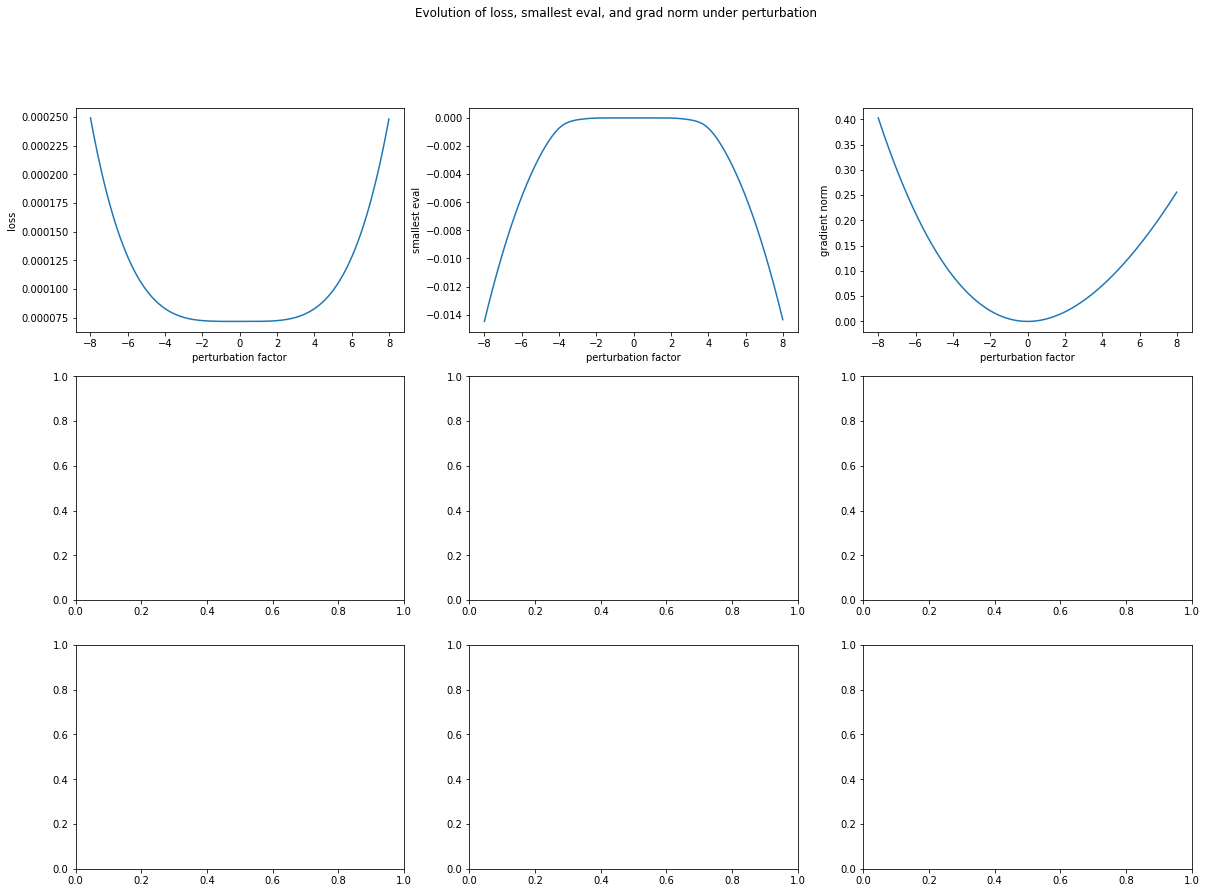

In [127]:
fig, axs = plt.subplots(3, 3)
fig.set_size_inches(20, 14)
fig.suptitle('Evolution of loss, smallest eval, and grad norm under perturbation')

axs[0, 0].plot(np.arange(perturb_lower_bound, perturb_upper_bound, perturb_step), perturb_losses)
axs[0, 0].ticklabel_format(useOffset=False)
axs[0, 0].set_xlabel('perturbation factor')
axs[0, 0].set_ylabel('loss')

axs[0, 1].plot(np.arange(perturb_lower_bound, perturb_upper_bound, perturb_step), perturb_evals)
axs[0, 1].set_xlabel('perturbation factor')
axs[0, 1].set_ylabel('smallest eval')

axs[0, 2].plot(np.arange(perturb_lower_bound, perturb_upper_bound, perturb_step), perturb_grads)
axs[0, 2].set_xlabel('perturbation factor')
axs[0, 2].set_ylabel('gradient norm')
